In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
#from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/EG-SC拟合残差_原油指数.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['EG-SC（期货指数）拟合残差/结算价:原油指数'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,EG-SC（期货指数）拟合残差/结算价:原油指数,PE-SC（期货指数）拟合残差/结算价:原油指数,石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透,新增社融滚动12个月累计同比,LME铜价同比,财新中国PMI,美国天然气HH连1合约-石脑油价格（CFR日本）,乙二醇备货量（聚酯工厂/公式计算）,乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合),乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差,乙二醇月度供需差
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet1 = pd.ExcelFile('eta/PE-SC拟合残差_SC_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,预测值
21,2025-11-10,-910.6
20,2025-11-11,-905.3
19,2025-11-12,-896.5
18,2025-11-13,-902.9
17,2025-11-14,-897.5


In [6]:
sheet2 = pd.ExcelFile('eta/石脑油-Brent拟合残差_Brent_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,预测值
24,2025-11-07,-9.0
23,2025-11-09,-8.2
22,2025-11-10,-6.9
21,2025-11-11,-6.7
20,2025-11-12,-6.4


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/铜/eta/LME铜价_合并数据.xlsx")
]

file_path3 = None
for path3 in file_paths3:       
    if os.path.isfile(path3):  # 确保是文件而不是目录
        file_path3 = path3
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.read_excel(file_path3, sheet_name='Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['真实值'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,预测值
21,2025-11-08,10670.4
20,2025-11-10,10673.0
19,2025-11-11,10674.6
18,2025-11-12,10677.9
17,2025-11-13,10679.6


In [8]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/天然气/eta/美国天然气HH连1合约_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/天然气/eta/美国天然气HH连1合约_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/天然气/eta/美国天然气HH连1合约_合并数据.xlsx")
]

file_path4 = None
for path4 in file_paths4:       
    if os.path.isfile(path4):  # 确保是文件而不是目录
        file_path4 = path4
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.read_excel(file_path4, sheet_name='Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['实际值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
    sheet4.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,美国天然气HH连1合约
19,2025-11-10,4.43
18,2025-11-11,4.42
17,2025-11-12,4.42
16,2025-11-13,4.39
15,2025-11-14,4.39


In [9]:
sheet5 = pd.ExcelFile('eta/石脑油价格_合并数据.xlsx').parse('Sheet1')
sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
sheet5 = sheet5.sort_values('Date', ascending=True)
sheet5 = sheet5.drop(columns=['石脑油价格（CFR日本）'])
sheet5 = sheet5.dropna()
sheet5.head()

,Date,石脑油价格（CFR日本）_预测
20,2025-11-07,579.779411
19,2025-11-10,582.033306
18,2025-11-11,586.182624
17,2025-11-12,585.983845
16,2025-11-13,586.198006


In [10]:
sheet4['HH-石脑油'] = sheet4['美国天然气HH连1合约'] - sheet5['石脑油价格（CFR日本）_预测']

In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PE-SC（期货指数）拟合残差/结算价:原油指数'] = sheet_daily['PE-SC（期货指数）拟合残差/结算价:原油指数'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透'] = sheet_daily['石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价同比'] = sheet_daily['LME铜价同比'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])



# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', 'HH-石脑油']],
    on='Date',
    how='left'
)
sheet_daily['美国天然气HH连1合约-石脑油价格（CFR日本）'] = sheet_daily['美国天然气HH连1合约-石脑油价格（CFR日本）'].fillna(sheet_daily['HH-石脑油'])
sheet_daily = sheet_daily.drop(columns=['HH-石脑油'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [12]:
sheet.columns

Index(['EG-SC（期货指数）拟合残差/结算价:原油指数', 'PE-SC（期货指数）拟合残差/结算价:原油指数',
       '石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透', '新增社融滚动12个月累计同比',
       'LME铜价同比', '财新中国PMI', '美国天然气HH连1合约-石脑油价格（CFR日本）', '乙二醇备货量（聚酯工厂/公式计算）',
       '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)',
       '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差', '乙二醇月度供需差'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
    'PE-SC（期货指数）拟合残差/结算价:原油指数':'interpolate',
    '石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透':'interpolate', 
    '新增社融滚动12个月累计同比':'interpolate',
    'LME铜价同比':'interpolate', 
    '财新中国PMI':'interpolate' , 
    '美国天然气HH连1合约-石脑油价格（CFR日本）':'interpolate', 
    '乙二醇备货量（聚酯工厂/公式计算）':'interpolate',
    '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)':'interpolate',
    '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差':'interpolate',
    #'乙二醇港口+聚酯工厂总库存/月频(预测/最新值动态环差)同差':'interpolate',
    '乙二醇月度供需差': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################
sheet['新增社融滚动12个月累计同比_提前120天'] = sheet['新增社融滚动12个月累计同比'].shift(120)
sheet['财新中国PMI_提前10天'] = sheet['财新中国PMI'].shift(10)
sheet['乙二醇备货量（聚酯工厂/公式计算）_提前10天'] = sheet['乙二醇备货量（聚酯工厂/公式计算）'].shift(10)
sheet['乙二醇月度供需差_提前42天'] = sheet['乙二醇月度供需差'].shift(42)


sheet['乙二醇备货量（聚酯工厂/公式计算）_提前10天_逆序'] = reverse_column(sheet, '乙二醇备货量（聚酯工厂/公式计算）_提前10天')
sheet['乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)_逆序'] = reverse_column(sheet, '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)')
sheet['乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差_逆序'] = reverse_column(sheet, '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差')
#sheet['乙二醇港口+聚酯工厂总库存/月频(预测/最新值动态环差)同差_逆序'] = reverse_column(sheet, '乙二醇港口+聚酯工厂总库存/月频(预测/最新值动态环差)同差')
sheet['乙二醇月度供需差_提前42天_逆序'] = reverse_column(sheet, '乙二醇月度供需差_提前42天')
'''
# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['乙烯下游加权开工率/周度超季节性/3年_提前10天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

sheet[['乙烯下游加权开工率/周度超季节性/3年_提前10天']]

'''
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['EG-SC（期货指数）拟合残差/结算价:原油指数'].notna())
]

################################# 数据 读取-处理 结束 #################################

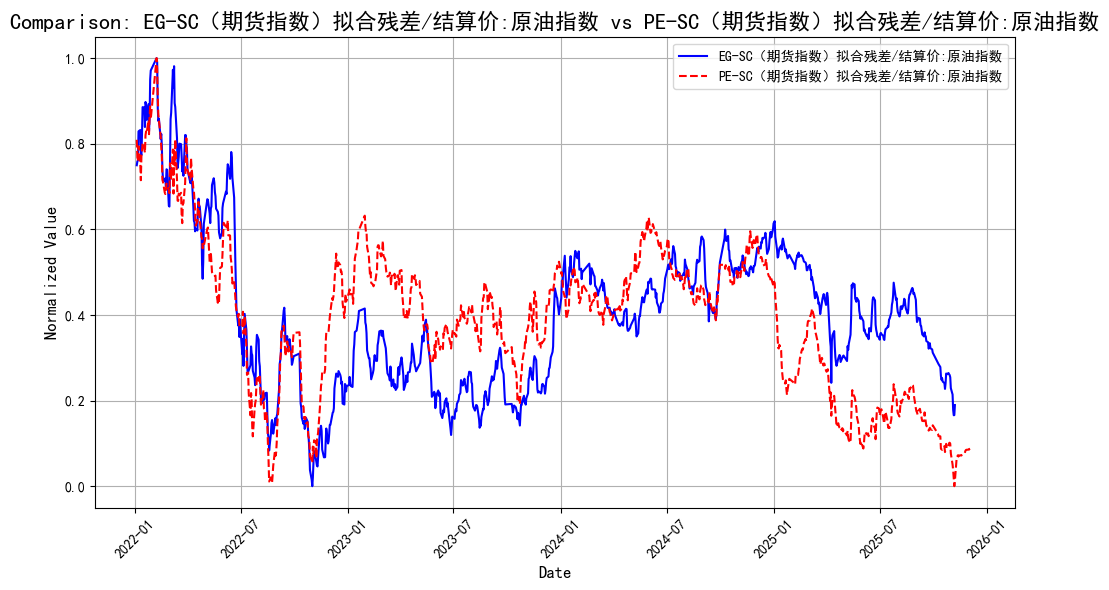

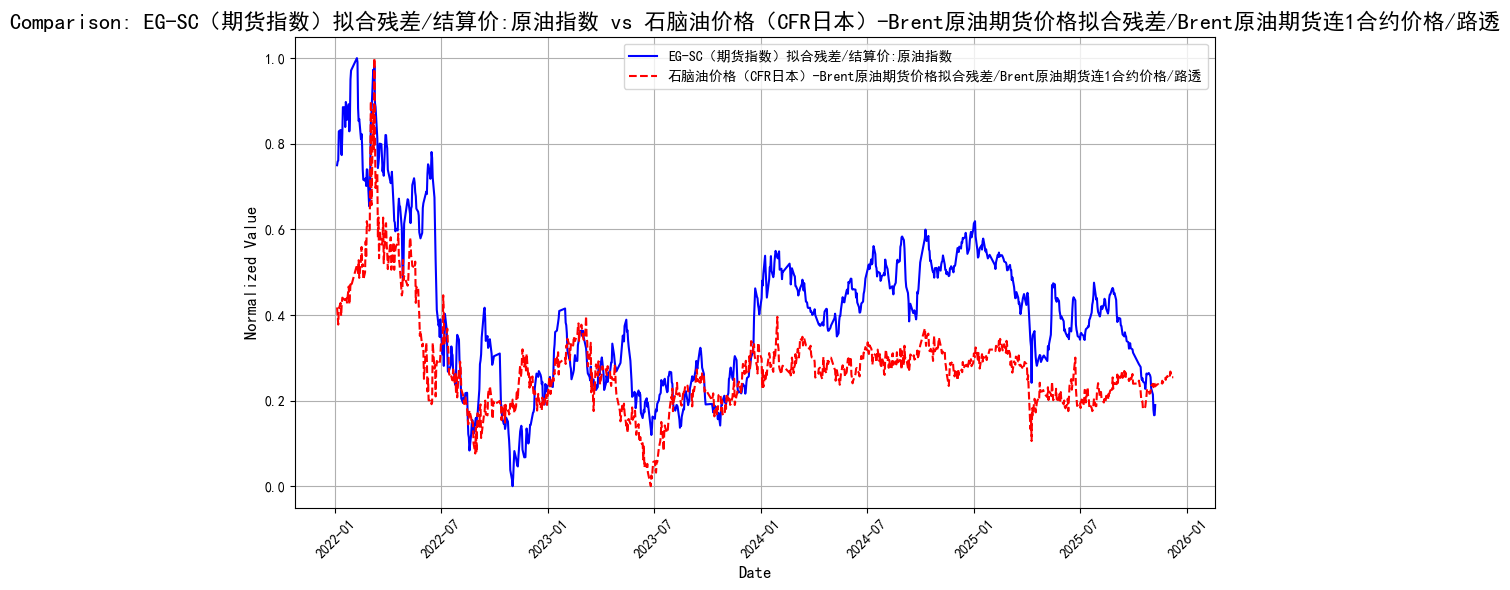

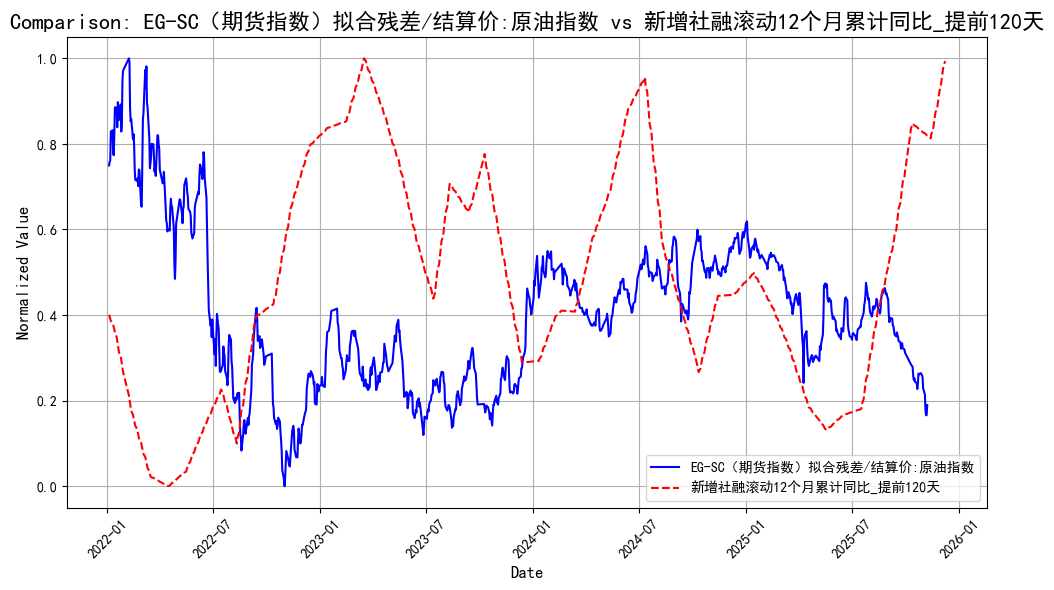

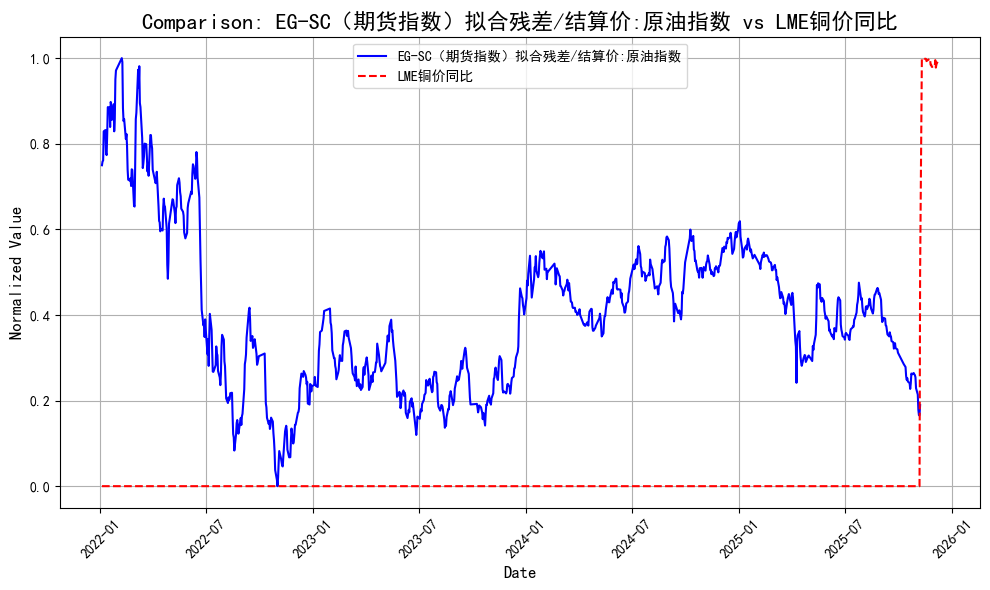

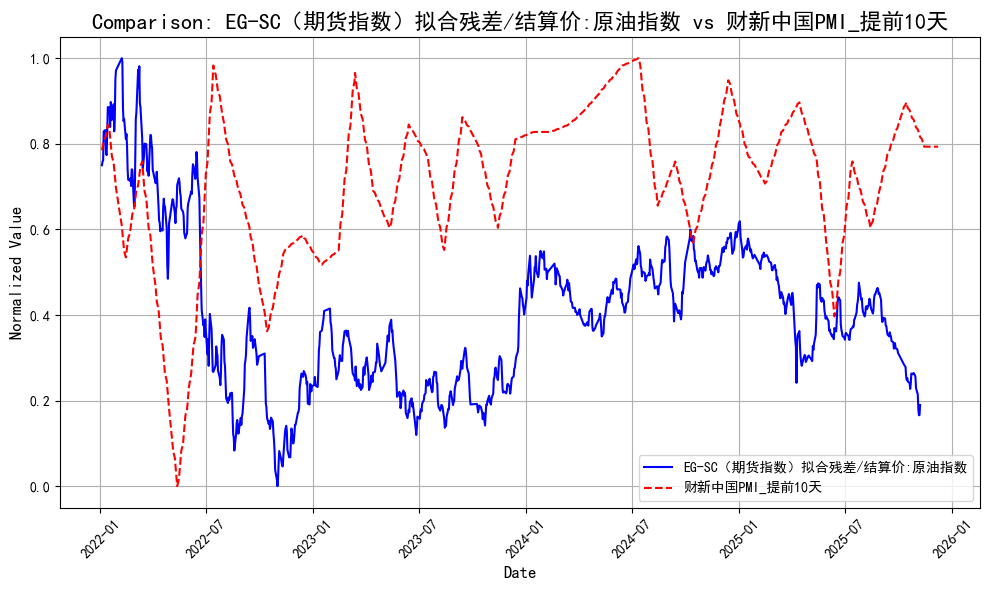

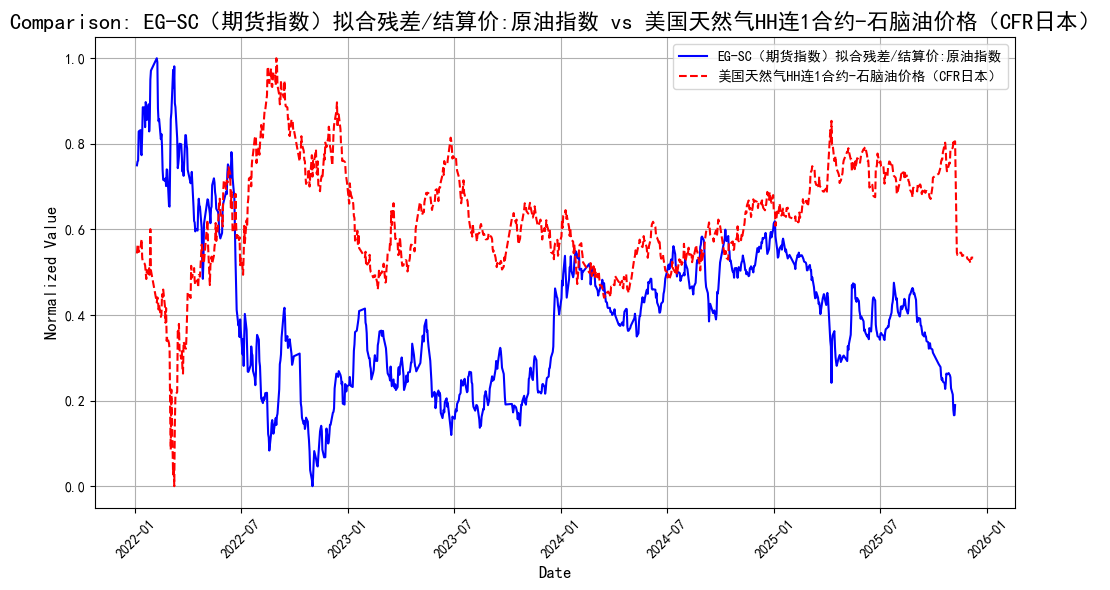

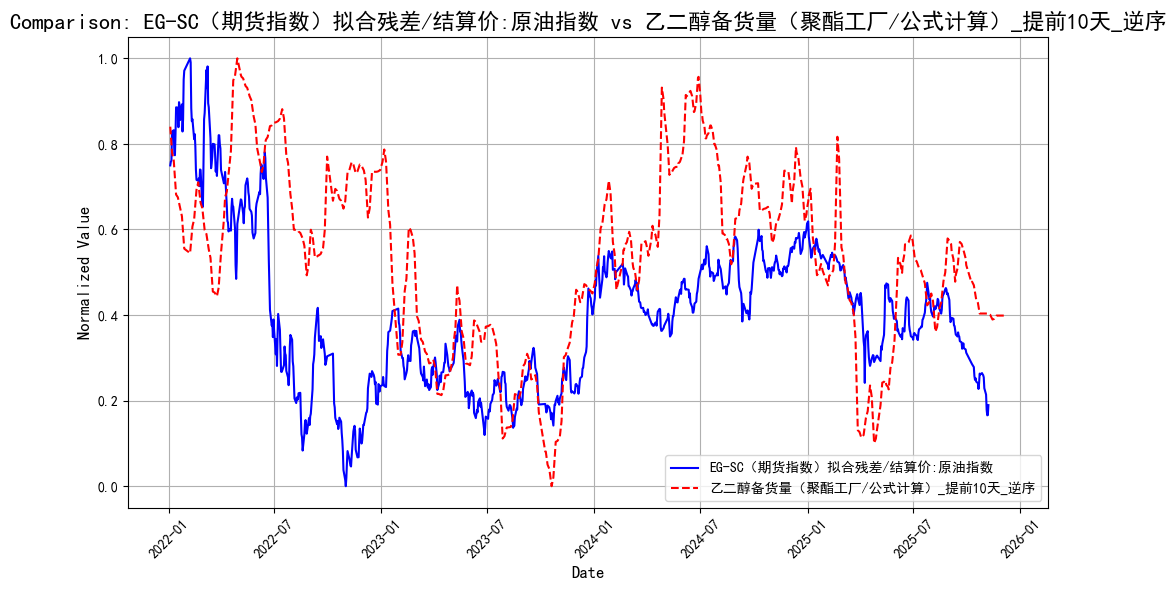

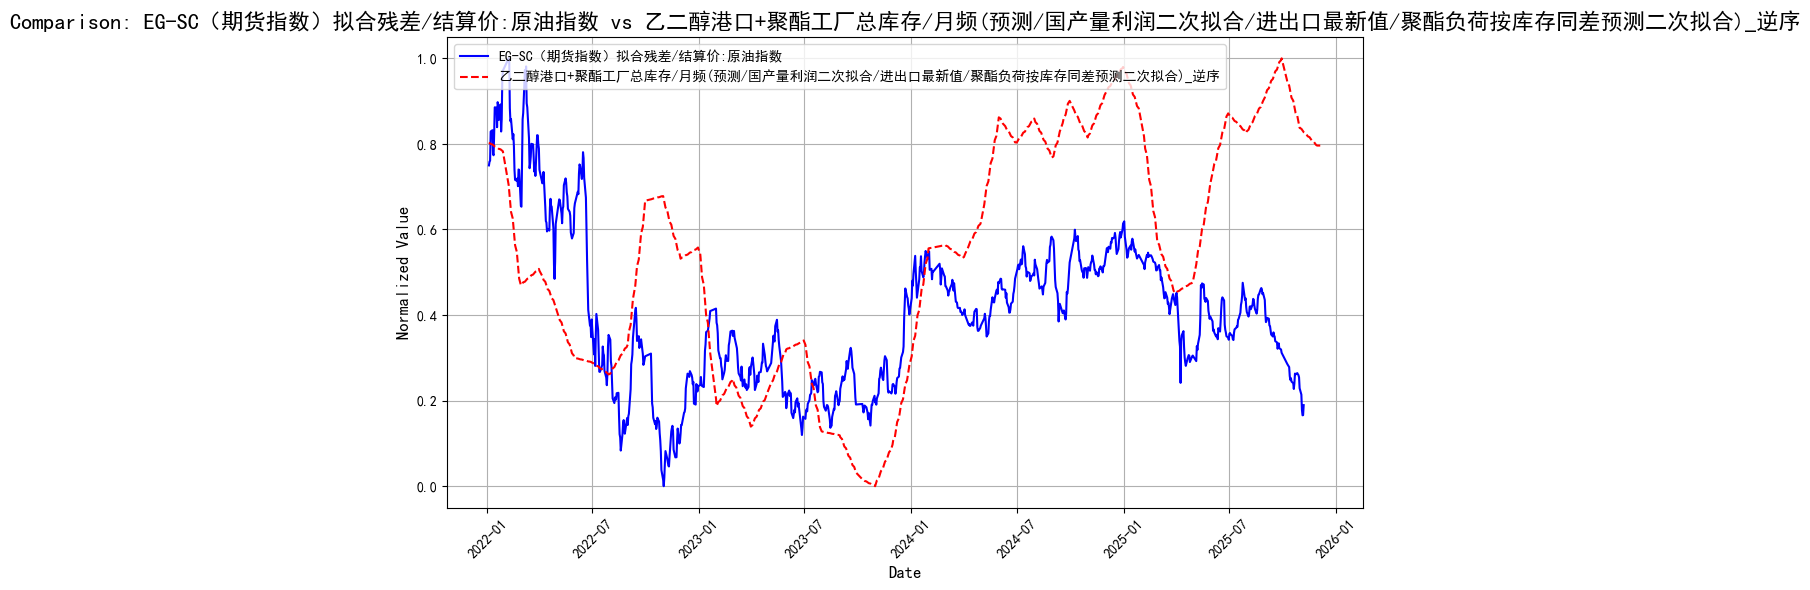

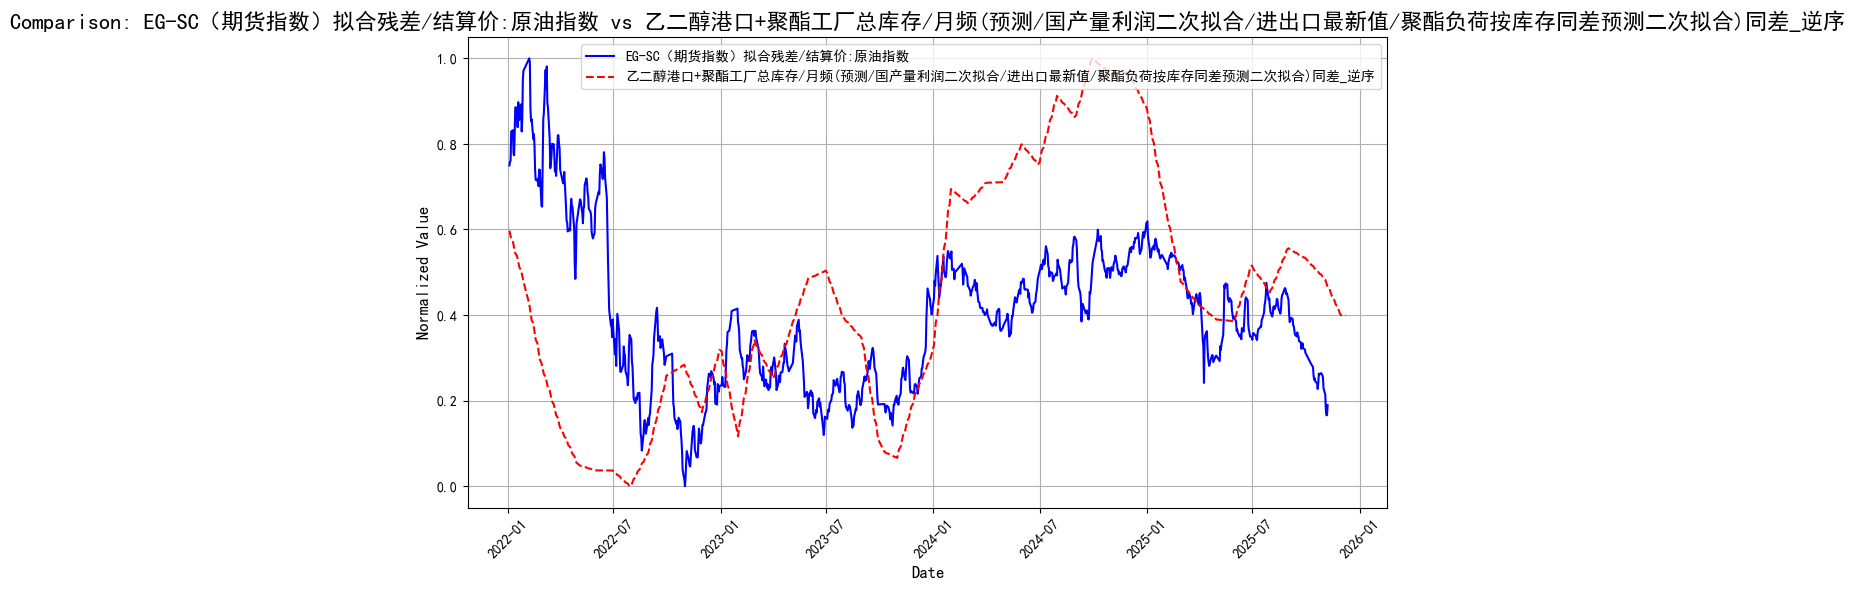

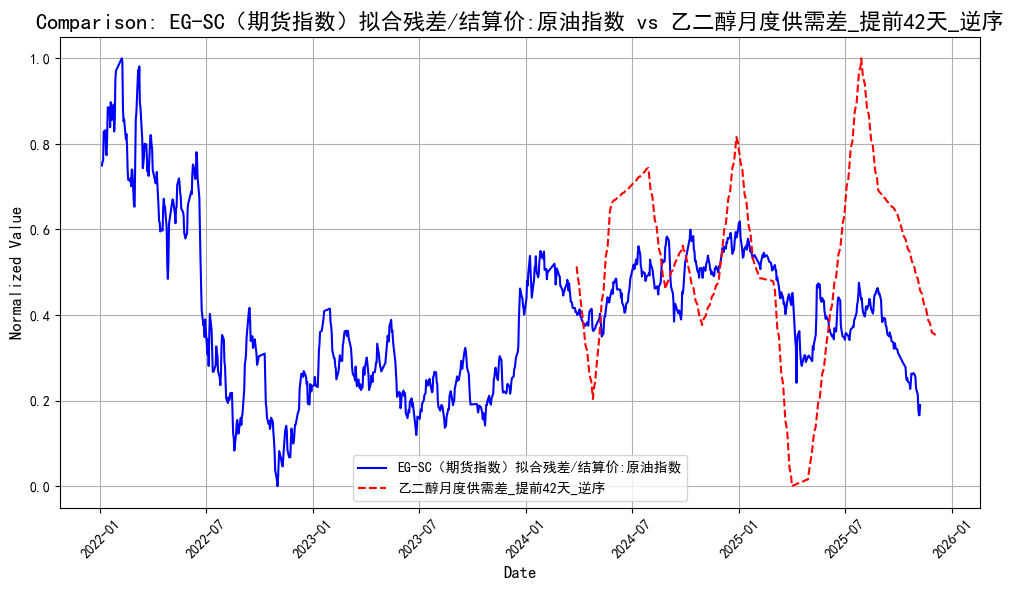

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='EG-SC（期货指数）拟合残差/结算价:原油指数', 
    compare_cols=[
        'PE-SC（期货指数）拟合残差/结算价:原油指数',
       '石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透', 
       '新增社融滚动12个月累计同比_提前120天',
       'LME铜价同比', 
       '财新中国PMI_提前10天', 
       '美国天然气HH连1合约-石脑油价格（CFR日本）', 
       '乙二醇备货量（聚酯工厂/公式计算）_提前10天_逆序',
       '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)_逆序',
       '乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差_逆序',
       #'乙二醇港口+聚酯工厂总库存/月频(预测/最新值动态环差)同差_逆序',
       '乙二醇月度供需差_提前42天_逆序'
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'PE-SC（期货指数）拟合残差/结算价:原油指数',
       '石脑油价格（CFR日本）-Brent原油期货价格拟合残差/Brent原油期货连1合约价格/路透', 
       '新增社融滚动12个月累计同比_提前120天',
       'LME铜价同比', 
       '财新中国PMI_提前10天', 
       '美国天然气HH连1合约-石脑油价格（CFR日本）', 
       '乙二醇备货量（聚酯工厂/公式计算）_提前10天_逆序',
       #'乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)_逆序',
       #'乙二醇港口+聚酯工厂总库存/月频(预测/国产量利润二次拟合/进出口最新值/聚酯负荷按库存同差预测二次拟合)同差_逆序'
       #'乙二醇港口+聚酯工厂总库存/月频(预测/最新值动态环差)同差_逆序',
       '乙二醇月度供需差_提前42天_逆序'
]

predict_column = 'EG-SC（期货指数）拟合残差/结算价:原油指数'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]


In [16]:

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 默认学习率
    'max_depth': 8,  # 默认树深度
    'min_child_weight': 0.6,  # 默认最小子节点权重
    'subsample': 0.5,  # 默认子采样比例
    'colsample_bytree': 0.4,  # 默认特征采样比例
    'gamma': 0.3,  # 默认最小分裂损失
    'reg_alpha': 0.7,  # 默认L1正则化
    'reg_lambda': 0.9,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round =31000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix


[0]	eval-rmse:309.38488	train-rmse:319.29325


[500]	eval-rmse:154.25806	train-rmse:25.27569


[1000]	eval-rmse:136.90003	train-rmse:11.49460


[1500]	eval-rmse:132.57223	train-rmse:6.67587


[2000]	eval-rmse:130.78397	train-rmse:4.14996


[2500]	eval-rmse:130.63524	train-rmse:2.68765


[3000]	eval-rmse:130.21141	train-rmse:1.81231


[3500]	eval-rmse:130.22510	train-rmse:1.26311


[4000]	eval-rmse:130.10455	train-rmse:0.90870


[4500]	eval-rmse:130.03873	train-rmse:0.69469


[5000]	eval-rmse:130.00959	train-rmse:0.57802


[5500]	eval-rmse:129.98716	train-rmse:0.51594


[6000]	eval-rmse:129.96441	train-rmse:0.48195


[6500]	eval-rmse:129.96329	train-rmse:0.46030


[7000]	eval-rmse:129.94868	train-rmse:0.44501


[7500]	eval-rmse:129.95305	train-rmse:0.43445


[8000]	eval-rmse:129.95855	train-rmse:0.42609


[8500]	eval-rmse:129.95183	train-rmse:0.41886


[9000]	eval-rmse:129.96406	train-rmse:0.41282


[9500]	eval-rmse:129.95344	train-rmse:0.40689


[10000]	eval-rmse:129.93513	train-rmse:0.40251


[10500]	eval-rmse:129.93055	train-rmse:0.39841


[11000]	eval-rmse:129.92876	train-rmse:0.39496


[11500]	eval-rmse:129.93069	train-rmse:0.39181


[12000]	eval-rmse:129.91932	train-rmse:0.38921


[12500]	eval-rmse:129.93742	train-rmse:0.38649


[13000]	eval-rmse:129.93234	train-rmse:0.38393


[13500]	eval-rmse:129.93597	train-rmse:0.38190


[14000]	eval-rmse:129.92443	train-rmse:0.37954


[14500]	eval-rmse:129.93204	train-rmse:0.37748


[15000]	eval-rmse:129.93951	train-rmse:0.37530


[15500]	eval-rmse:129.92896	train-rmse:0.37353


[16000]	eval-rmse:129.92520	train-rmse:0.37184


[16500]	eval-rmse:129.93170	train-rmse:0.37027


[17000]	eval-rmse:129.93435	train-rmse:0.36867


[17500]	eval-rmse:129.93611	train-rmse:0.36731


[18000]	eval-rmse:129.93971	train-rmse:0.36580


[18500]	eval-rmse:129.94569	train-rmse:0.36446


[19000]	eval-rmse:129.94874	train-rmse:0.36325


[19500]	eval-rmse:129.94469	train-rmse:0.36215


[20000]	eval-rmse:129.94244	train-rmse:0.36102


[20500]	eval-rmse:129.94764	train-rmse:0.35994


[21000]	eval-rmse:129.94775	train-rmse:0.35901


[21500]	eval-rmse:129.94983	train-rmse:0.35781


[22000]	eval-rmse:129.94903	train-rmse:0.35683


[22500]	eval-rmse:129.94844	train-rmse:0.35584


[23000]	eval-rmse:129.93911	train-rmse:0.35500


[23500]	eval-rmse:129.94507	train-rmse:0.35419


[24000]	eval-rmse:129.93756	train-rmse:0.35317


[24500]	eval-rmse:129.93775	train-rmse:0.35233


[25000]	eval-rmse:129.94105	train-rmse:0.35146


[25500]	eval-rmse:129.93709	train-rmse:0.35062


[26000]	eval-rmse:129.94770	train-rmse:0.34968


[26500]	eval-rmse:129.94858	train-rmse:0.34883


[27000]	eval-rmse:129.94527	train-rmse:0.34809


[27500]	eval-rmse:129.94642	train-rmse:0.34740


[28000]	eval-rmse:129.94770	train-rmse:0.34684


[28500]	eval-rmse:129.94898	train-rmse:0.34616


[29000]	eval-rmse:129.94570	train-rmse:0.34539


[29500]	eval-rmse:129.94710	train-rmse:0.34456


[30000]	eval-rmse:129.94904	train-rmse:0.34407


[30500]	eval-rmse:129.94697	train-rmse:0.34340


[30999]	eval-rmse:129.94775	train-rmse:0.34272


训练集 MSE (DMatrix): 0.1219, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 16886.4165, 测试集 R² (DMatrix): -3.2199


In [17]:

################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all


[0]	train-rmse:318.71047


[500]	train-rmse:25.23237


[1000]	train-rmse:11.66378


[1500]	train-rmse:6.92335


[2000]	train-rmse:4.40515


[2500]	train-rmse:2.90695


[3000]	train-rmse:1.99763


[3500]	train-rmse:1.39986


[4000]	train-rmse:1.01686


[4500]	train-rmse:0.76698


[5000]	train-rmse:0.62184


[5500]	train-rmse:0.54216


[6000]	train-rmse:0.50048


[6500]	train-rmse:0.47408


[7000]	train-rmse:0.45699


[7500]	train-rmse:0.44450


[8000]	train-rmse:0.43443


[8500]	train-rmse:0.42687


[9000]	train-rmse:0.42038


[9500]	train-rmse:0.41418


[10000]	train-rmse:0.40972


[10500]	train-rmse:0.40481


[11000]	train-rmse:0.40122


[11500]	train-rmse:0.39799


[12000]	train-rmse:0.39490


[12500]	train-rmse:0.39198


[13000]	train-rmse:0.38927


[13500]	train-rmse:0.38675


[14000]	train-rmse:0.38436


[14500]	train-rmse:0.38225


[15000]	train-rmse:0.38014


[15500]	train-rmse:0.37790


[16000]	train-rmse:0.37618


[16500]	train-rmse:0.37464


[17000]	train-rmse:0.37307


[17500]	train-rmse:0.37160


[18000]	train-rmse:0.37020


[18500]	train-rmse:0.36895


[19000]	train-rmse:0.36763


[19500]	train-rmse:0.36632


[20000]	train-rmse:0.36507


[20500]	train-rmse:0.36401


[21000]	train-rmse:0.36273


[21500]	train-rmse:0.36175


[22000]	train-rmse:0.36068


[22500]	train-rmse:0.35967


[23000]	train-rmse:0.35874


[23500]	train-rmse:0.35792


[24000]	train-rmse:0.35680


[24500]	train-rmse:0.35610


[25000]	train-rmse:0.35532


[25500]	train-rmse:0.35440


[26000]	train-rmse:0.35360


[26500]	train-rmse:0.35280


[27000]	train-rmse:0.35202


[27500]	train-rmse:0.35130


[28000]	train-rmse:0.35061


[28500]	train-rmse:0.34993


[29000]	train-rmse:0.34929


[29500]	train-rmse:0.34863


[30000]	train-rmse:0.34804


[30500]	train-rmse:0.34752


[30999]	train-rmse:0.34683


全部数据 MSE: 0.127, 全部数据 R²: 1.0


In [18]:
'''
################################# TabPFN 模型 训练 测试 预测 #################################

# 初始化回归器
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

'''

'\n################################# TabPFN 模型 训练 测试 预测 #################################\n\n# 初始化回归器\nregressor = TabPFNRegressor()\nregressor.fit(X_train, y_train)\n\n# 在测试集和未来数据上预测\ny_train_pred = regressor.predict(X_train)\ny_test_pred = regressor.predict(X_test)\n\n\n# 评估模型\ntrain_mse = mean_squared_error(y_train, y_train_pred)\ntrain_r2 = r2_score(y_train, y_train_pred)\ntest_mse = mean_squared_error(y_test, y_test_pred)\ntest_r2 = r2_score(y_test, y_test_pred)\n\nprint(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")\nprint(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")\n\n# 存储预测结果\ny_future_pred = regressor.predict(X_future)\ntest_data.loc[:, \'预测值\'] = y_test_pred\nfuture_data.loc[:, \'预测值\'] = y_future_pred\n\n'

In [19]:
'''

################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor()
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all
'''

'\n\n################################# TabPFN 模型 训练 测试 预测 所有数据 #################################\n# 合并所有数据\nX_all = pd.concat([X_train, X_test]).reset_index(drop=True)\ny_all = pd.concat([y_train, y_test]).reset_index(drop=True)\n\n# 初始化回归器\nregressor_all = TabPFNRegressor()\nregressor_all.fit(X_all, y_all)\n\n# 预测所有数据和未来数据\ny_all_pred = regressor_all.predict(X_all)\ny_future_pred_all = regressor_all.predict(X_future)\n\n# 评估模型\nall_mse = mean_squared_error(y_all, y_all_pred)\nall_r2 = r2_score(y_all, y_all_pred)\n\nprint(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")\n\n# 存储全部数据的预测结果\nall_data = pd.concat([train_data, test_data]).reset_index(drop=True)\nall_data.loc[:, \'预测值_全量\'] = y_all_pred\nfuture_data.loc[:, \'预测值_全量\'] = y_future_pred_all\n'

In [20]:
'''
# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=regressor_all,
    X=X_all,
    y=y_all,
    n_features_to_select=5,  # How many features to select
    feature_names=X_all.columns,
)

# Print selected features
selected_features = [
    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")
'''

'\n# Feature selection\nsfs = interpretability.feature_selection.feature_selection(\n    estimator=regressor_all,\n    X=X_all,\n    y=y_all,\n    n_features_to_select=5,  # How many features to select\n    feature_names=X_all.columns,\n)\n\n# Print selected features\nselected_features = [\n    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]\n]\nprint("\nSelected features:")\nfor feature in selected_features:\n    print(f"- {feature}")\n'

In [21]:
'''
# Get a TabPFNExplainer
n_model_evals = 500
x_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组
explainer = tabpfn_shapiq.get_tabpfn_explainer(
    model=regressor_all,
    data=X_all,
    labels=X_all, 
    index="SV",  # SV: Shapley Value (like in shap)
    verbose=True,  # show a progress bar during explanation
)

# Get shap values
print("计算SHAP值...")
shapley_values = explainer.explain(x=x_explain, budget=n_model_evals)

# plot the force plot
shapley_values.plot_force(feature_names=X_all.columns)
'''

'\n# Get a TabPFNExplainer\nn_model_evals = 500\nx_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组\nexplainer = tabpfn_shapiq.get_tabpfn_explainer(\n    model=regressor_all,\n    data=X_all,\n    labels=X_all, \n    index="SV",  # SV: Shapley Value (like in shap)\n    verbose=True,  # show a progress bar during explanation\n)\n\n# Get shap values\nprint("计算SHAP值...")\nshapley_values = explainer.explain(x=x_explain, budget=n_model_evals)\n\n# plot the force plot\nshapley_values.plot_force(feature_names=X_all.columns)\n'

In [22]:
'''
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
'''

"\nplt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')\nplt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') \nplt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)\nplt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')\nplt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')\nplt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')\n"

Gap between last actual value and first prediction: -139.53261508789063


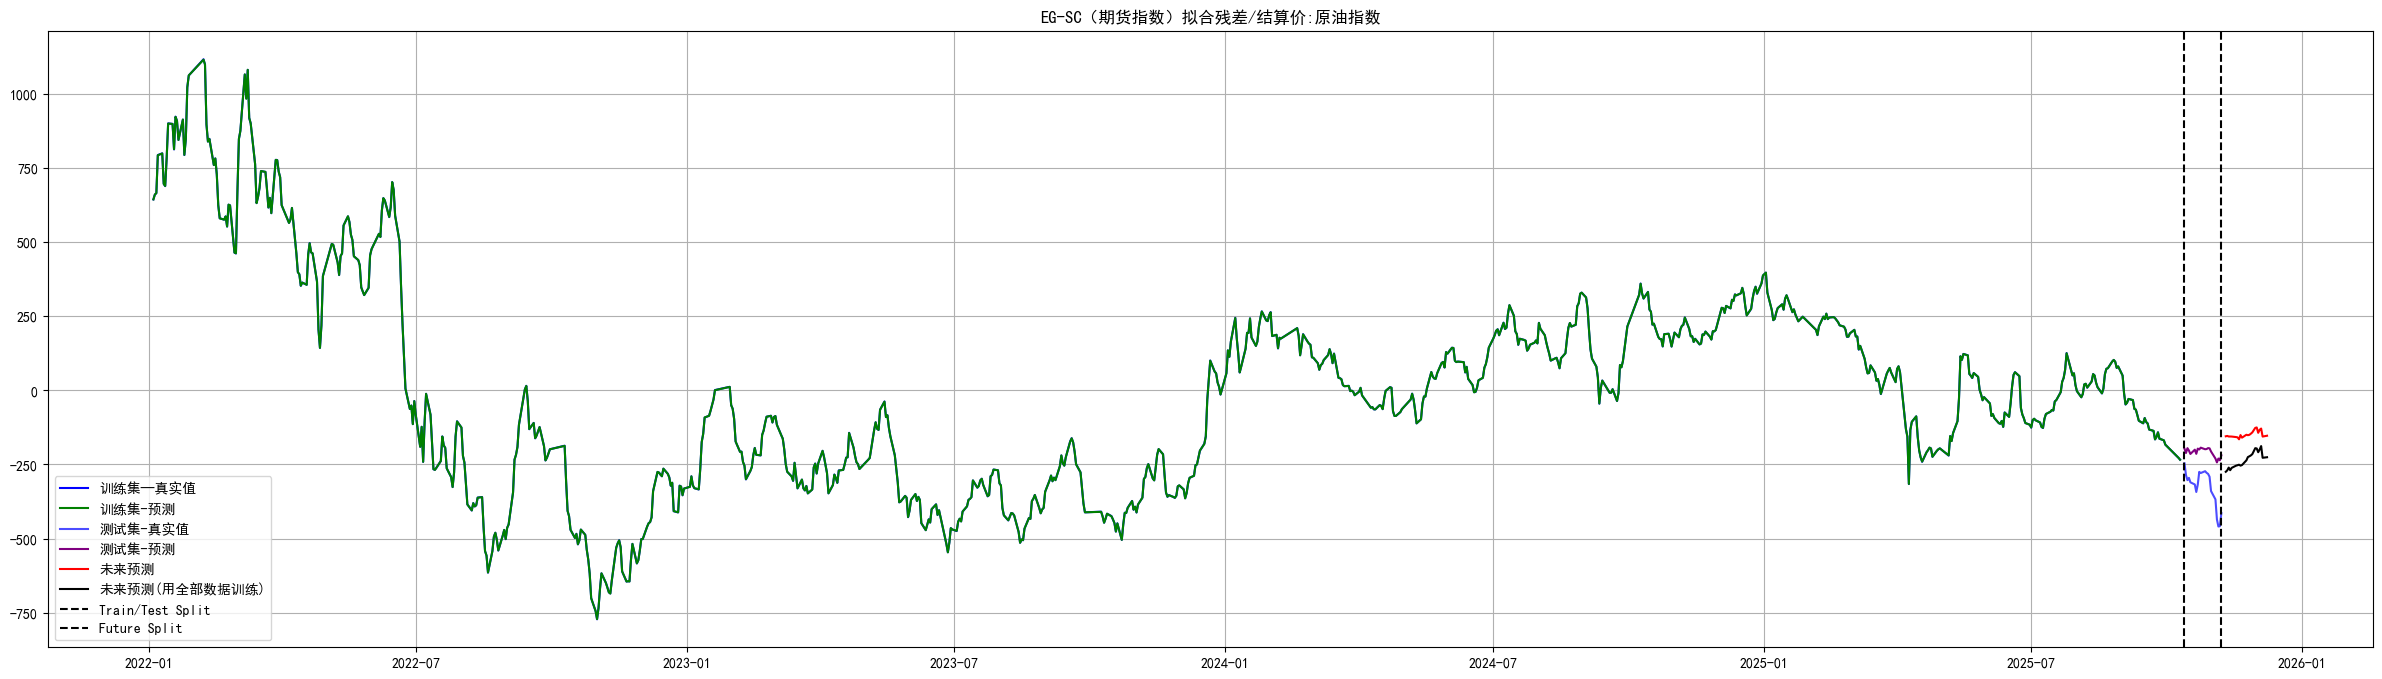

In [23]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
#plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
#plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')


# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('EG-SC（期货指数）拟合残差/结算价:原油指数')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/EG-SC拟合残差_SC_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
710,2025/12/08,NaN,-225.885788
709,2025/12/05,NaN,-227.714600
708,2025/12/04,NaN,-188.253601
707,2025/12/03,NaN,-199.819427
706,2025/12/02,NaN,-208.941803
...,...,...,...
4,2023/01/09,-334.6198,NaN
3,2023/01/06,-330.3127,NaN
2,2023/01/05,-320.4564,NaN
1,2023/01/04,-290.2501,NaN


In [25]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    #'预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
# 只保留2024年10月1日之后的预测值
merged_df_monthly.loc[merged_df_monthly.index < pd.Timestamp('2024-10-01'), '预测值'] = None

merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/EG-SC拟合残差_SC_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
23,2025/12/31,NaN,-207.819397
22,2025/11/30,-427.246940,-241.741928
21,2025/10/31,-288.386194,-204.948166
20,2025/09/30,-95.510827,-95.531342
19,2025/08/31,39.451524,39.478504
18,2025/07/31,-34.176009,-34.162636
17,2025/06/30,-62.826720,-62.852654
16,2025/05/31,-9.804005,-9.805764
15,2025/04/30,-150.994957,-150.983398
14,2025/03/31,80.757805,80.741997


In [26]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "EG-SC（期货指数）拟合残差/结算价:原油指数"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [27]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "EG-SC（期货指数）拟合残差/结算价:原油指数"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [28]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'SC期货指数-Brent原油期货价格',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'SC期货指数-Brent原油期货价格\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'